## 7. Make LFP
This step needs to be done after basic spike band filtering as we process the same electrodes.

In [38]:
%reload_ext autoreload
%autoreload 2

In [39]:
#dj.conn() 
#dj.config

In [40]:
import os
import numpy as np
import pandas as pd

import spyglass as nd
import datajoint as dj
import multiprocessing

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)
warnings.simplefilter('ignore', category=UserWarning)

import matplotlib.pyplot as plt

In [23]:
# We also import a bunch of tables so that we can call them easily
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode)
from spyglass.common import (RawPosition, StateScriptFile, VideoFile,
                                  DataAcquisitionDevice, CameraDevice, Probe,
                                  DIOEvents,
                                  ElectrodeGroup, Electrode, Raw, SampleCount,
                                  LFPSelection, LFP, LFPBandSelection, LFPBand,
                                  PositionSource,
                                  IntervalList, 
                                  Lab, LabMember, LabTeam, Institution,
                                  BrainRegion,
                                  SensorData,
                                  Session,
                                  Subject,
                                  Task, TaskEpoch,
                                  Nwbfile, AnalysisNwbfile, AnalysisNwbfileKachery) #SortGroup, SpikeSorting, SpikeSorter, SpikeSorterParameters, 
                                  #SpikeSortingWaveformParameters, SpikeSortingParameters, SpikeSortingMetrics, CuratedSpikeSorting, AutomaticCurationSpikeSortingParameters,SortInterval,
    
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,)
from spyglass.common import FirFilterParameters

from spyglass.shijiegu.load import load_session_name
from spyglass.shijiegu.ripple_detection import loadRippleLFP_OneChannelPerElectrode

In [24]:
FirFilterParameters()

filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,filter_type,filter_low_stop lowest frequency for stop band for low frequency side of filter,filter_low_pass lowest frequency for pass band of low frequency side of filter,filter_high_pass highest frequency for pass band for high frequency side of filter,filter_high_stop highest frequency for stop band of high frequency side of filter,filter_comments comments about the filter,filter_band_edges numpy array containing the filter bands (redundant with individual parameters),filter_coeff numpy array containing the filter coefficients
Delta 0.5-4 Hz,1000,lowpass,0.25,0.5,4.0,5.0,delta filter for 1 KHz data,=BLOB=,=BLOB=
"Delta 0.5-4 Hz pass, 0.25-4.5 Hz stop",1000,lowpass,0.25,0.5,4.0,4.5,revised delta filter for 1 KHz data,=BLOB=,=BLOB=
Epilepsy project 0.2-40 Hz,2000,bandpass,0.1,0.2,40.0,41.0,Sharp wave filter,=BLOB=,=BLOB=
Epilepsy project 140-800 Hz,2000,bandpass,135.0,140.0,800.0,825.0,Extended ripple filter,=BLOB=,=BLOB=
Epilepsy project 140-800 Hz ripple,2000,bandpass,135.0,140.0,800.0,825.0,Extended ripple filter,=BLOB=,=BLOB=
Epilepsy project 40-600 Hz,2000,bandpass,39.0,40.0,600.0,625.0,HFE filter,=BLOB=,=BLOB=
Fast Gamma 65-100 Hz,1000,bandpass,55.0,65.0,100.0,110.0,slow gamma filter for 1 Khz data,=BLOB=,=BLOB=
LFP 0-100 Hz,30000,lowpass,0.0,0.0,100.0,125.0,LFP filter 0-100 Hz,=BLOB=,=BLOB=
LFP 0-400 Hz,1000,lowpass,0.0,0.0,400.0,425.0,LFP filter for referencing,=BLOB=,=BLOB=
LFP 0-400 Hz,20000,lowpass,0.0,0.0,400.0,425.0,standard LFP filter for 20 KHz data,=BLOB=,=BLOB=


### The only cell to be edited:

In [111]:
nwb_file_name = 'molly20220419.nwb'

### Run the rest

In [112]:
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)

#### 1. Select Electrodes to do LFP

In [97]:
Electrode() & {'nwb_file_name' : nwb_copy_file_name}

nwb_file_name name of the NWB file,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,probe_id,probe_shank shank number within probe,probe_electrode electrode,region_id,name unique label for each contact,original_reference_electrode the configured reference electrode for this electrode,x the x coordinate of the electrode position in the brain,y the y coordinate of the electrode position in the brain,z the z coordinate of the electrode position in the brain,filtering description of the signal filtering,impedance electrode impedance,"bad_channel if electrode is ""good"" or ""bad"" as observed during recording",x_warped x coordinate of electrode position warped to common template brain,y_warped y coordinate of electrode position warped to common template brain,z_warped z coordinate of electrode position warped to common template brain,contacts label of electrode contacts used for a bipolar signal - current workaround
molly20220419_.nwb,0,0,tetrode_12.5,0,0,19,0,64,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
molly20220419_.nwb,0,1,tetrode_12.5,0,1,19,1,64,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
molly20220419_.nwb,0,2,tetrode_12.5,0,2,19,2,64,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
molly20220419_.nwb,0,3,tetrode_12.5,0,3,19,3,64,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
molly20220419_.nwb,1,4,tetrode_12.5,0,0,19,4,64,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
molly20220419_.nwb,1,5,tetrode_12.5,0,1,19,5,64,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
molly20220419_.nwb,1,6,tetrode_12.5,0,2,19,6,64,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
molly20220419_.nwb,1,7,tetrode_12.5,0,3,19,7,64,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
molly20220419_.nwb,10,40,tetrode_12.5,0,0,19,40,64,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,
molly20220419_.nwb,10,41,tetrode_12.5,0,1,19,41,64,0.0,0.0,0.0,None,0.0,False,0.0,0.0,0.0,


In [98]:
(SortGroup() & {'nwb_file_name' : nwb_copy_file_name}) #&{'electrode_group_name' : 2})

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,"sort_reference_electrode_id the electrode to use for reference. -1: no reference, -2: common median"
molly20220419_.nwb,0,64
molly20220419_.nwb,1,64
molly20220419_.nwb,2,64
molly20220419_.nwb,3,64
molly20220419_.nwb,4,64
molly20220419_.nwb,5,64
molly20220419_.nwb,6,64
molly20220419_.nwb,7,64
molly20220419_.nwb,8,64
molly20220419_.nwb,9,64


In [99]:
# find tetrodes
groups_with_cell=(SpikeSortingRecordingSelection & {'nwb_file_name' : nwb_copy_file_name}).fetch('sort_group_id')
groups_with_cell
groups_with_cell=np.setdiff1d(groups_with_cell,[100,101])

# find electrodes and the corresponding reference_electrode
electrodes=[]
electrodes_ref=[]
for e in groups_with_cell:
    key=(Electrode() & {'nwb_file_name' : nwb_copy_file_name} &{'electrode_group_name' : e})
    electrodes_=key.fetch('electrode_id')
    
    electrodes_ref_=(SortGroup & {'nwb_file_name' : nwb_copy_file_name,
                                  'sort_group_id':e}).fetch('sort_reference_electrode_id')
    
    if len(electrodes_)>0:
        electrodes.append(electrodes_)
        electrodes_ref.append(electrodes_ref_*np.ones((len(electrodes_))).astype('int'))
        
electrodes=np.concatenate(electrodes)
electrodes_ref=np.concatenate(electrodes_ref)

electrodes=np.concatenate([electrodes,np.unique(electrodes_ref)])
electrodes_ref=np.concatenate([electrodes_ref,np.unique(electrodes_ref)])

In [100]:
electrodes

array([  0,   1,   2,   3,   8,   9,  10,  11,  12,  13,  14,  15,  24,
        25,  26,  27,  28,  29,  30,  31,  36,  37,  38,  39,  40,  41,
        42,  43,  48,  49,  50,  51,  60,  61,  62,  63,  68,  69,  70,
        71,  72,  73,  74,  75,  96,  97,  98,  99, 100, 101, 102, 103,
       108, 109, 110, 111, 136, 137, 138, 139, 148, 149, 150, 151, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 184, 185,
       186, 187, 200, 201, 202, 203, 208, 209, 210, 211, 212, 213, 214,
       215, 240, 241, 242, 243, 244, 245, 246, 247,  64, 193])

In [101]:
electrodes_ref

array([ 64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,
        64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,
        64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,
        64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,
        64,  64,  64,  64, 193, 193, 193, 193, 193, 193, 193, 193, 193,
       193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193,
       193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193,
       193, 193, 193, 193, 193, 193, 193, 193, 193,  64, 193])

In [102]:
assert len(electrodes) == len(electrodes_ref)
print(len(electrodes))

102


In [103]:
'''if you want to delete an entry'''
#(LFPSelection() & {'nwb_file_name' :nwb_copy_file_name}).delete()

'if you want to delete an entry'

In [104]:
LFPSelection().set_lfp_electrodes(nwb_copy_file_name, electrodes.tolist())

[21:55:57][INFO] Spyglass: Queueing delete for session(s):
*nwb_file_name *lab_member_na
+------------+ +------------+
molly20220419_ Shijie Gu     
 (Total: 1)

[21:55:58][INFO] Spyglass: Building merge cache for l_f_p_selection.
	Found 1 downstream merge tables
[2025-04-10 21:55:58,188][INFO]: Deleting 10 rows from `cbroz_temp`.`__which_nans`
[2025-04-10 21:55:58,226][INFO]: Deleting 10 rows from `common_ephys`.`__l_f_p_band`
[2025-04-10 21:55:58,320][INFO]: Deleting 1180 rows from `common_ephys`.`l_f_p_band_selection__l_f_p_band_electrode`
[2025-04-10 21:55:58,346][INFO]: Deleting 10 rows from `common_ephys`.`l_f_p_band_selection`
[2025-04-10 21:55:58,367][INFO]: Deleting 1 rows from `common_ephys`.`_l_f_p`
[2025-04-10 21:55:58,424][INFO]: Deleting 118 rows from `common_ephys`.`l_f_p_selection__l_f_p_electrode`
[2025-04-10 21:55:58,441][INFO]: Deleting 1 rows from `common_ephys`.`l_f_p_selection`


#### 2. do standard low pass filter

In [105]:
#(LFP() & {'nwb_file_name':nwb_copy_file_name}).delete()

In [ ]:
LFP().populate({'nwb_file_name':nwb_copy_file_name})

[21:56:03][INFO] Spyglass: LFP: found 11 of 11 intervals > 1.0 sec long.
[21:56:04][INFO] Spyglass: Writing new NWB file molly20220419_DYIFV8Y8E8.nwb
[21:58:32][INFO] Spyglass: Filtering data
[21:58:32][INFO] Spyglass: Interval 0: loading data into memory


In [113]:
print('here')

here


In [114]:
print(nwb_copy_file_name)
LFP & {'nwb_file_name':nwb_copy_file_name}

molly20220419_.nwb


nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,analysis_file_name name of the file,lfp_object_id the NWB object ID for loading this object from the file,"lfp_sampling_rate the sampling rate, in HZ"
molly20220419_.nwb,lfp valid times,LFP 0-400 Hz,30000,molly20220419_DYIFV8Y8E8.nwb,54ff621c-eb64-433b-9261-f6e145d64396,1000.0


#### 3. do theta/ripple band filter

In [115]:
intervals = (TaskEpoch & {'nwb_file_name': nwb_copy_file_name}).fetch('interval_list_name')

In [116]:
(TaskEpoch & {'nwb_file_name': nwb_copy_file_name})

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),task_name,camera_name,interval_list_name descriptive name of this interval list,task_environment the environment the animal was in,camera_names list of keys corresponding to entry in CameraDevice
molly20220419_.nwb,1,sleep,sleep_camera,01_Seq2Sleep1,none,=BLOB=
molly20220419_.nwb,2,maze,maze_camera,02_Seq2Session1,none,=BLOB=
molly20220419_.nwb,3,sleep,sleep_camera,03_Seq2Sleep2,none,=BLOB=
molly20220419_.nwb,4,maze,maze_camera,04_Seq2Session2,none,=BLOB=
molly20220419_.nwb,5,sleep,sleep_camera,05_Seq2Sleep3,none,=BLOB=
molly20220419_.nwb,6,maze,maze_camera,06_Seq2Session3,none,=BLOB=
molly20220419_.nwb,7,sleep,sleep_camera,07_Seq2Sleep4,none,=BLOB=
molly20220419_.nwb,8,maze,maze_camera,08_Seq2Session4,none,=BLOB=
molly20220419_.nwb,9,sleep,sleep_camera,09_Seq2Sleep5,none,=BLOB=
molly20220419_.nwb,10,maze,maze_camera,10_Seq2Session5,none,=BLOB=


In [117]:
# get sleep and run epoch

session_interval, sleep_interval = load_session_name(nwb_copy_file_name)
print(session_interval)
print(sleep_interval)

['02_Seq2Session1', '04_Seq2Session2', '06_Seq2Session3', '08_Seq2Session4', '10_Seq2Session5']
['01_Seq2Sleep1', '03_Seq2Sleep2', '05_Seq2Sleep3', '07_Seq2Sleep4', '09_Seq2Sleep5', '11_Seq2Sleep6']


In [60]:
"""
(LFPBandSelection() & {'nwb_file_name':nwb_copy_file_name,
   'filter_name':'Theta 5-11 Hz pass, 4.5-12 Hz stop'}).delete()
(LFPBandSelection() & {'nwb_file_name':nwb_copy_file_name,
   'filter_name':'Ripple 150-250 Hz'}).delete()
"""

"\n(LFPBandSelection() & {'nwb_file_name':nwb_copy_file_name,\n   'filter_name':'Theta 5-11 Hz pass, 4.5-12 Hz stop'}).delete()\n(LFPBandSelection() & {'nwb_file_name':nwb_copy_file_name,\n   'filter_name':'Ripple 150-250 Hz'}).delete()\n"

In [118]:
for intv_list_name in session_interval: #+sleep_interval:
    print(intv_list_name)
    filter_name='Ripple 150-250 Hz'
    interval_list_name=intv_list_name #'02_Seq2Session1'

    '''
    # for one electrode
    lfp_band_sampling_rate= (FirFilterParameters() & {'filter_name':'Ripple 150-250 Hz'}).fetch1('filter_sampling_rate')
    electrodes=(LFPSelection().LFPElectrode() & {'nwb_file_name':nwb_copy_file_name,'electrode_group_name' : 3}).fetch('electrode_id')
    ref_elect=[electrodes_ref[0]]
    LFPBandSelection().set_lfp_band_electrodes(nwb_copy_file_name, [electrodes[0]], 
                                               filter_name,
                                               interval_list_name, ref_elect, lfp_band_sampling_rate)
    '''

    # for all electrodes
    elect=electrodes.tolist()
    ref_elect=electrodes_ref.tolist()
    
    print('about to set lfp')
    
    lfp_band_sampling_rate= (FirFilterParameters() & {'filter_name':'Ripple 150-250 Hz'}).fetch1('filter_sampling_rate')
    LFPBandSelection().set_lfp_band_electrodes(nwb_copy_file_name, elect, 
                                               filter_name,
                                               interval_list_name, ref_elect, lfp_band_sampling_rate)


02_Seq2Session1
about to set lfp
04_Seq2Session2
about to set lfp
06_Seq2Session3
about to set lfp
08_Seq2Session4
about to set lfp
10_Seq2Session5
about to set lfp


In [119]:
for intv_list_name in session_interval: #+sleep_interval:
    print(intv_list_name)
    filter_name='Theta 5-11 Hz pass, 4.5-12 Hz stop'
    interval_list_name=intv_list_name #'02_Seq2Session1'
    '''
    # for one electrode
    lfp_band_sampling_rate= (FirFilterParameters() & {'filter_name':filter_name}).fetch1('filter_sampling_rate')
    electrodes=(LFPSelection().LFPElectrode() & {'nwb_file_name':nwb_copy_file_name,'electrode_group_name' : 3}).fetch('electrode_id')
    ref_elect=[electrodes_ref[0]]
    LFPBandSelection().set_lfp_band_electrodes(nwb_copy_file_name, [electrodes[0]], 
                                               filter_name,
                                               interval_list_name, ref_elect, lfp_band_sampling_rate)
    '''

    # for all electrodes
    elect=electrodes.tolist()
    ref_elect=electrodes_ref.tolist()
    
    print('about to set lfp')
    
    lfp_band_sampling_rate= (FirFilterParameters() & {'filter_name':filter_name}).fetch1('filter_sampling_rate')
    LFPBandSelection().set_lfp_band_electrodes(nwb_copy_file_name, elect, 
                                               filter_name,
                                               interval_list_name, np.zeros_like(ref_elect)-1, lfp_band_sampling_rate)


02_Seq2Session1
about to set lfp
04_Seq2Session2
about to set lfp
06_Seq2Session3
about to set lfp
08_Seq2Session4
about to set lfp
10_Seq2Session5
about to set lfp


In [120]:
LFPBand().populate(LFPBandSelection() & {'nwb_file_name' : nwb_copy_file_name})

[2025-04-11 07:30:24,094][WARNING]: Skipped checksum for file with hash: db487cf4-2333-efe8-29ac-1076ba3bbf42, and path: /stelmo/nwb/analysis/molly20220419/molly20220419_DYIFV8Y8E8.nwb
[07:31:31][INFO] Spyglass: Writing new NWB file molly20220419_KE4B3BRUIP.nwb
[07:31:32][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1650389602.3813853 < 1650389602.3810854
[2025-04-11 07:31:47,781][WARNING]: Skipped checksum for file with hash: db487cf4-2333-efe8-29ac-1076ba3bbf42, and path: /stelmo/nwb/analysis/molly20220419/molly20220419_DYIFV8Y8E8.nwb
[07:32:00][INFO] Spyglass: Writing new NWB file molly20220419_Y9LQRHTHDI.nwb
[07:32:01][WARNING] Spyglass: Interval time warning: stop time larger than last timestamp, substituting last: 1650389602.3813853 < 1650389602.3810854
[2025-04-11 07:32:18,668][WARNING]: Skipped checksum for file with hash: db487cf4-2333-efe8-29ac-1076ba3bbf42, and path: /stelmo/nwb/analysis/molly20220419/molly20220419_DYIFV8

In [121]:
(LFPBand() & {'nwb_file_name' :nwb_copy_file_name})

nwb_file_name name of the NWB file,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,analysis_file_name name of the file,interval_list_name descriptive name of this interval list,filtered_data_object_id the NWB object ID for loading this object from the file
molly20220419_.nwb,Ripple 150-250 Hz,1000,02_Seq2Session1,1000,molly20220419_KE4B3BRUIP.nwb,02_Seq2Session1 lfp band 1000Hz,79edf15f-a7bc-48f7-94c4-42b6c65f5357
molly20220419_.nwb,Ripple 150-250 Hz,1000,04_Seq2Session2,1000,molly20220419_2DUXJ4C3VW.nwb,04_Seq2Session2 lfp band 1000Hz,c0f8a359-7a0e-4230-8084-8740e5b88a9f
molly20220419_.nwb,Ripple 150-250 Hz,1000,06_Seq2Session3,1000,molly20220419_RIL93WU2TS.nwb,06_Seq2Session3 lfp band 1000Hz,2a5110fb-2d8b-45c3-bce0-3605ac1c62ee
molly20220419_.nwb,Ripple 150-250 Hz,1000,08_Seq2Session4,1000,molly20220419_VBYDSFCQK2.nwb,08_Seq2Session4 lfp band 1000Hz,b3eaf47a-80ae-4b1d-8386-f04cb0cbc4e1
molly20220419_.nwb,Ripple 150-250 Hz,1000,10_Seq2Session5,1000,molly20220419_34M8GRQF5I.nwb,10_Seq2Session5 lfp band 1000Hz,5846a1d5-d8f7-409d-88b5-d9483e408344
molly20220419_.nwb,"Theta 5-11 Hz pass, 4.5-12 Hz stop",1000,02_Seq2Session1,1000,molly20220419_Y9LQRHTHDI.nwb,02_Seq2Session1 lfp band 1000Hz,e93d0a54-3a63-491a-ac94-dfe84e10bb43
molly20220419_.nwb,"Theta 5-11 Hz pass, 4.5-12 Hz stop",1000,04_Seq2Session2,1000,molly20220419_3E7XVFOMHS.nwb,04_Seq2Session2 lfp band 1000Hz,0dc17639-45e6-4623-af85-220b8b1c560b
molly20220419_.nwb,"Theta 5-11 Hz pass, 4.5-12 Hz stop",1000,06_Seq2Session3,1000,molly20220419_6EM42NZKZU.nwb,06_Seq2Session3 lfp band 1000Hz,88717341-351b-484a-ada4-177f540b00a2
molly20220419_.nwb,"Theta 5-11 Hz pass, 4.5-12 Hz stop",1000,08_Seq2Session4,1000,molly20220419_ZELVGO3XVJ.nwb,08_Seq2Session4 lfp band 1000Hz,abf0d2c5-4614-42e7-9b2f-bd5ac0de3605
molly20220419_.nwb,"Theta 5-11 Hz pass, 4.5-12 Hz stop",1000,10_Seq2Session5,1000,molly20220419_Q72VIOQ141.nwb,10_Seq2Session5 lfp band 1000Hz,dae6c1df-faf0-4aea-9928-7d4f7470268f


#### 4. Sanity check: plot reference and all channels to check whether referencing is done correctly.

In [122]:
session_interval, sleep_interval = load_session_name(nwb_copy_file_name)
target_interval = session_interval[0]

position_valid_times = (IntervalList & {'nwb_file_name': nwb_copy_file_name,
                                        'interval_list_name': target_interval}).fetch1('valid_times')
filtered_lfps, filtered_lfps_t, CA1TetrodeInd, CCTetrodeInd = loadRippleLFP_OneChannelPerElectrode(
        nwb_copy_file_name,target_interval,position_valid_times,'filtered data',1)

Using LFP from these eletrodes: 
[ 0  2  3  6  7  9 10 12 15 17 18 24 25 27 34 37 39 40 41 46 50 52 53 60
 61]




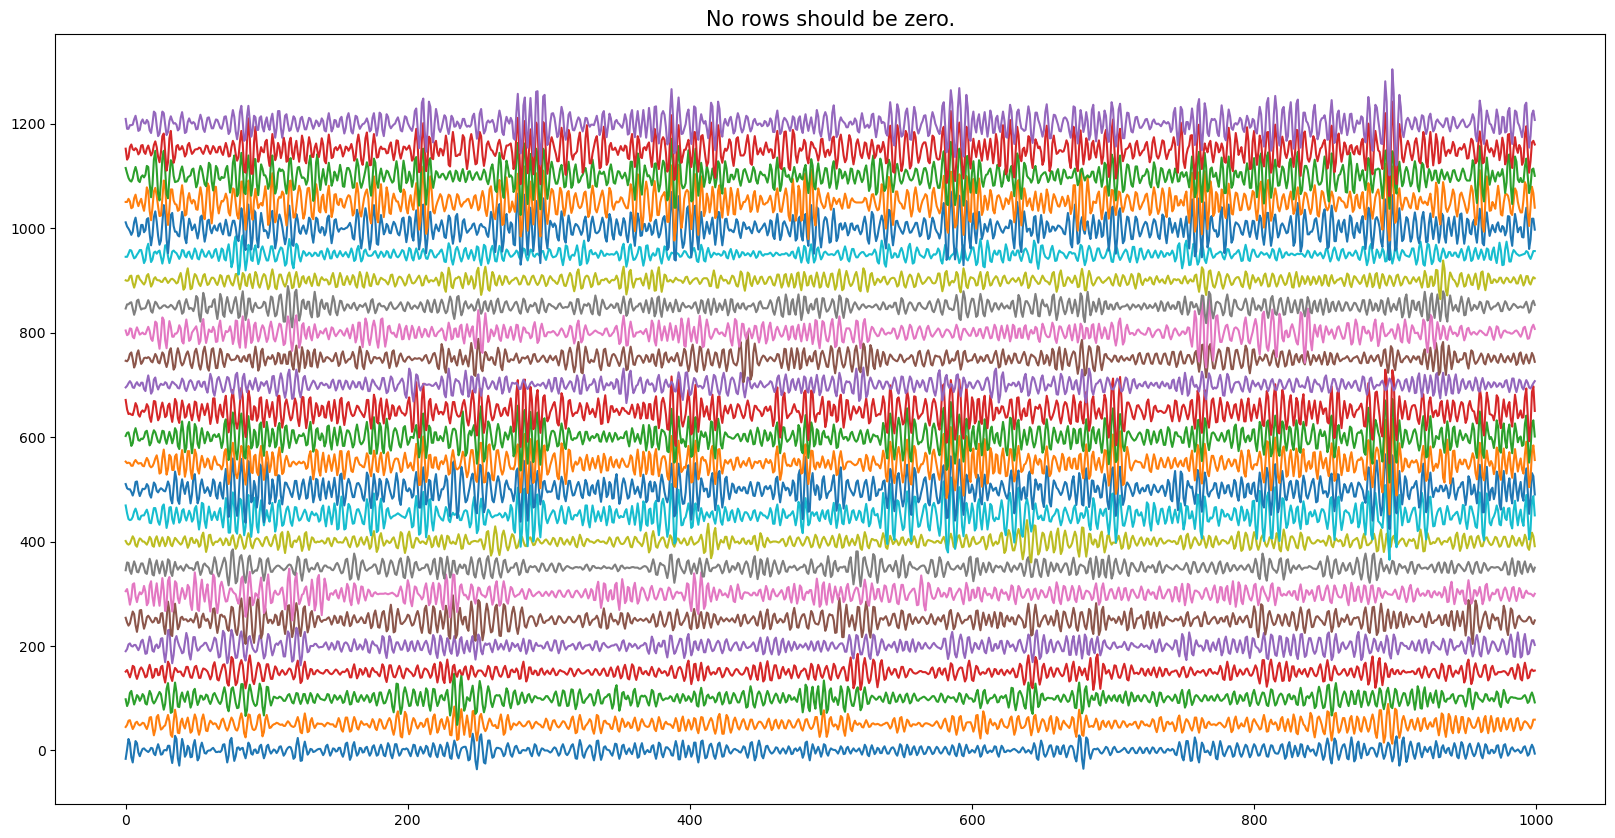

In [123]:
plt.subplots(ncols=1,nrows=1,figsize=(20,10))
r_ind = 0
for i in CA1TetrodeInd:
    plt.plot(filtered_lfps[50000:51000,i]+r_ind*50);
    r_ind += 1;
plt.title('No rows should be zero.',size = 15);

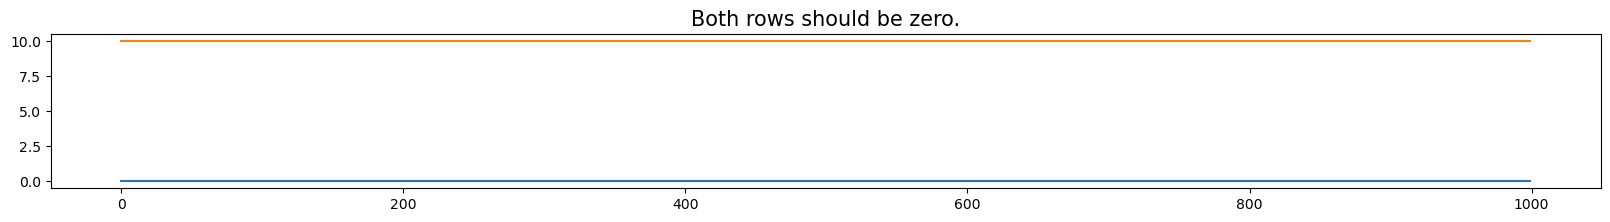

In [124]:
plt.subplots(ncols=1,nrows=1,figsize=(20,2))
r_ind = 0
for i in CCTetrodeInd:
    plt.plot(filtered_lfps[50000:51000,i]+r_ind*10);
    r_ind += 1;
plt.title('Both rows should be zero.',size = 15);

#### 5. To delete an entry

In [49]:
'''Delete an entry'''
#(LFPBand() & {'nwb_file_name' :nwb_copy_file_name,'target_interval_list_name':'04_Seq2Session2'}).delete()

Deleting 1 rows from `common_ephys`.`__l_f_p_band`


Commit deletes? [yes, No]:  yes


Deletes committed.


1

## END HERE

#### filter only "run sessions" for now

In [66]:
epoch_name = '02_Rev3Session1'
lfp_nwb=(LFP & {'nwb_file_name': nwb_copy_file_name,
            'target_interval_list_name':epoch_name}).fetch_nwb()

[2024-11-18 11:49:47,802][WARNING]: Skipped checksum for file with hash: 31bcbcc4-9313-5a07-6db5-e9bbc424491d, and path: /stelmo/nwb/analysis/haydn20230604/haydn20230604_FU9XP8HX85.nwb


In [67]:
lfp_data=lfp_nwb[0]['lfp'].data

In [69]:
lfp_timestamps=np.array(lfp_nwb[0]['lfp'].timestamps)

In [70]:
lfp_timestamps.shape

(19778055,)

In [68]:
lfp_data.shape

(19778055, 41)

In [72]:
# find tetrodes and the corresponding reference_electrode
groups_with_cell=(SpikeSortingRecordingSelection & {'nwb_file_name' : nwb_copy_file_name}).fetch('sort_group_id')
groups_with_cell=np.setdiff1d(groups_with_cell,[100,101])

electrodes_ref=[]
for e in groups_with_cell:
    key=(Electrode() & {'nwb_file_name' : nwb_copy_file_name} &{'electrode_group_name' : e})
    electrodes_=key.fetch('electrode_id')
    
    electrodes_ref_=(SortGroup & {'nwb_file_name' : nwb_copy_file_name,
                                  'sort_group_id':e}).fetch('sort_reference_electrode_id')
    if len(electrodes_)>0:
        electrodes_ref.append(electrodes_ref_*np.ones((len(electrodes_))).astype('int'))
        
electrodes_ref=np.unique(electrodes_ref)

In [73]:
electrodes_ref

array([ 4, 72])

In [17]:
lfp_data=lfp_nwb[0]['lfp'].data
lfp_timestamps=np.array(lfp_nwb[0]['lfp'].timestamps)

In [77]:
LFP_electrodes=np.array(list(lfp_nwb[0]['lfp'].electrodes.data))

In [79]:
np.isin(LFP_electrodes,electrodes_ref)

array([ True,  True])

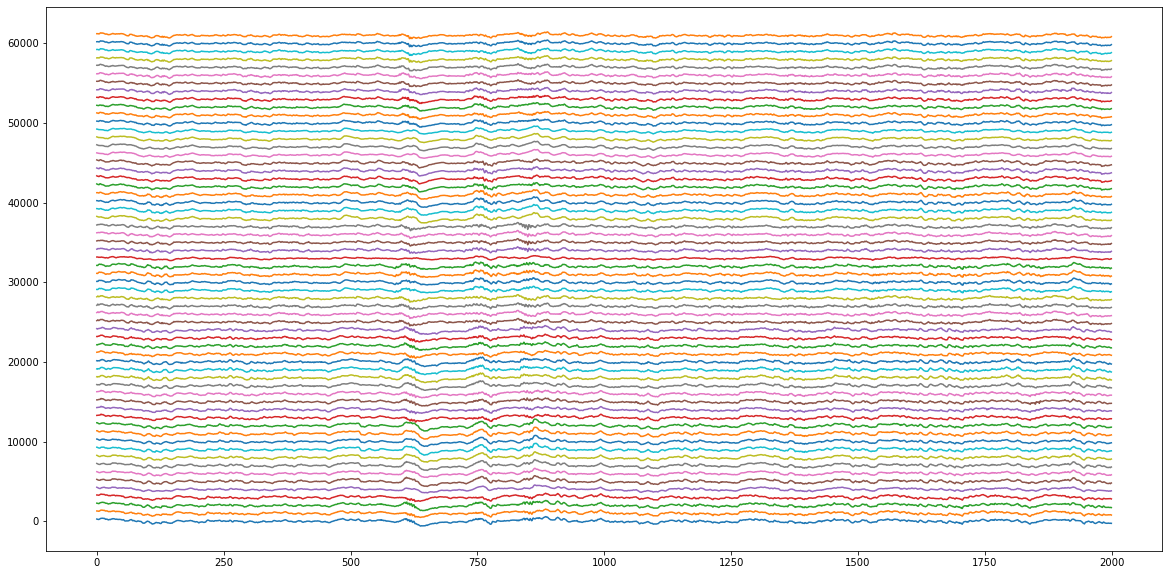

In [58]:
plt.figure(figsize=(20,10))
t1=88000 #75000
t2=t1+2000
for i in range(lfp_data.shape[1]):
    plt.plot(lfp_data[t1:t2,i]+1000*i)
    #plt.plot(lfp_data[t1:t2,0])
    #plt.plot(lfp_data[t1:t2,-1])

In [18]:
electrode_keys = (LFPSelection.LFPElectrode & key).fetch('KEY')

In [40]:
LFP()&{'nwb_file_name':nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,analysis_file_name name of the file,lfp_object_id the NWB object ID for loading this object from the file,"lfp_sampling_rate the sampling rate, in HZ"
molly20220415_.nwb,lfp valid times,LFP 0-400 Hz,30000,molly20220415_YQD3FYMEG9.nwb,2258037c-7d1d-4ec8-a6ae-1067b1fc4ffb,1000.0


In [ ]:
lowpass(selections[0])

working on tetrode  3
interval_list_name  02_Seq2Session1


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/base.py:167: UserWarning: Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("Length of data does not match length of timestamps. Your data may be transposed. Time should be on "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


LFP: found 1 of 1 intervals > 1.0 sec long.


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/base.py:167: UserWarning: Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("Length of data does not match length of timestamps. Your data may be transposed. Time should be on "


Writing new NWB file molly20220416_WDAD096FWC.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


In [13]:
tetrode_interval_list_name=selections[0]
tetrode=tetrode_interval_list_name[0]
interval_list_name=tetrode_interval_list_name[1]
key={'nwb_file_name':nwb_copy_file_name,'interval_list_name': interval_list_name}

In [ ]:
LFP() & {'nwb_file_name':nwb_copy_file_name}

In [ ]:
sampling_rate, interval_list_name = (Raw() & key).fetch1('sampling_rate', 'interval_list_name')

In [ ]:
#LFP().populate([LFPSelection & {'nwb_file_name':nwb_copy_file_name}])

In [24]:
LFP & {'nwb_file_name':nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,analysis_file_name name of the file,lfp_object_id the NWB object ID for loading this object from the file,"lfp_sampling_rate the sampling rate, in HZ"
molly20220420_.nwb,lfp valid times,LFP 0-400 Hz,30000,molly20220420_58C6M3SGI8.nwb,6f54fce9-5ba8-457c-b600-b6a91046527b,1000.0


#### 3. do theta/ripple band filter

In [54]:
#(IntervalList() & {'nwb_file_name':nwb_copy_file_name}).fetch('interval_list_name')

In [23]:
(LFPBandSelection() & {'nwb_file_name' :nwb_copy_file_name})

nwb_file_name name of the NWB file,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,min_interval_len the minimum length of a valid interval to filter
molly20220416_.nwb,Ripple 150-250 Hz,1000,02_Seq2Session1,1000,1.0
molly20220416_.nwb,Ripple 150-250 Hz,1000,04_Seq2Session2,1000,1.0
molly20220416_.nwb,Ripple 150-250 Hz,1000,06_Seq2Session3,1000,1.0
molly20220416_.nwb,Ripple 150-250 Hz,1000,08_Seq2Session4,1000,1.0
molly20220416_.nwb,Ripple 150-250 Hz,1000,10_Seq2Session5,1000,1.0


In [24]:
LFPBand().populate(LFPBandSelection() & {'nwb_file_name' : nwb_copy_file_name})

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_FAT9AKG1K4.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/base.py:167: UserWarning: Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("Length of data does not ma

Writing new NWB file molly20220416_3VNDUKRCP7.nwb
Interval stop time 1650138099.6804779 is larger than last timestamp 1650138099.6803775, using last timestamp instead


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_3VNDUKRCP7.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:275: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_FAT9AKG1

Writing new NWB file molly20220416_E25011CFZC.nwb
Interval stop time 1650142890.4811482 is larger than last timestamp 1650142890.4810774, using last timestamp instead


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_E25011CFZC.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:275: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_FAT9AKG1

Writing new NWB file molly20220416_S11FBDR1Q2.nwb
Interval stop time 1650146871.9814355 is larger than last timestamp 1650146871.9813447, using last timestamp instead


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_S11FBDR1Q2.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:275: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_FAT9AKG1

Writing new NWB file molly20220416_OQ5SXSRYAP.nwb
Interval stop time 1650151262.0815215 is larger than last timestamp 1650151262.0810175, using last timestamp instead


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_OQ5SXSRYAP.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:275: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_FAT9AKG1

Writing new NWB file molly20220416_AAIRJ4C4OY.nwb
Interval stop time 1650154867.2815697 is larger than last timestamp 1650154867.2809181, using last timestamp instead


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_AAIRJ4C4OY.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:275: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


In [23]:
LFPBand() & {'nwb_file_name' : nwb_copy_file_name}

nwb_file_name name of the NWB file,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,analysis_file_name name of the file,interval_list_name descriptive name of this interval list,filtered_data_object_id the NWB object ID for loading this object from the file


In [7]:
raw_eseries = (Raw() & {'nwb_file_name' : nwb_copy_file_name,
                       'electrode_group_name' : 7}).fetch_nwb()[0]['raw']

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/raw/molly20220416_.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/base.py:167: UserWarning: Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("Length of data does not match length of timestamps. Your data may be transposed. Time should be on "


KeyError: '07774c35-a02f-46d8-9cb4-2d90749e073e'

In [8]:
ripple_eseries_all=(LFPBand() & {'nwb_file_name' : nwb_copy_file_name}).fetch_nwb()

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_3OMWOSRN8F.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_BBGZPELQXU.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220416_SX6OBZOOLP.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly

In [9]:
run1times = (IntervalList & {'nwb_file_name': nwb_copy_file_name, 'interval_list_name' : '02_Seq2Session1'}).fetch1('valid_times')
plottimes = [run1times[0][0] + 101, run1times[0][0] + 102]


In [14]:
ripple_eseries=ripple_eseries_all[0]

In [19]:
ripple_eseries

{'nwb_file_name': 'molly20220416_.nwb',
 'filter_name': 'Ripple 150-250 Hz',
 'filter_sampling_rate': 1000,
 'target_interval_list_name': '02_Seq2Session1',
 'lfp_band_sampling_rate': 1000,
 'analysis_file_name': 'molly20220416_3OMWOSRN8F.nwb',
 'interval_list_name': '02_Seq2Session1 lfp band 1000Hz',
 'filtered_data_object_id': '237aa057-9db5-41d0-8225-062310a9a962',
 'filtered_data': filtered data pynwb.ecephys.ElectricalSeries at 0x139743322074608
 Fields:
   comments: no comments
   conversion: 1.0
   data: <HDF5 dataset "data": shape (2221581, 1), type "<i2">
   description: no description
   electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
   interval: 1
   resolution: -1.0
   timestamps: <HDF5 dataset "timestamps": shape (2221581,), type "<f8">
   timestamps_unit: seconds
   unit: volts}

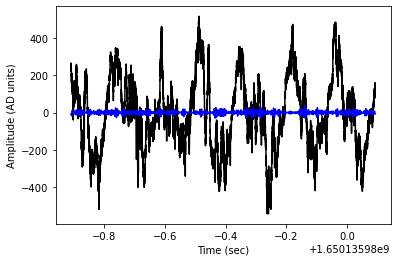

In [46]:
orig_elect_indeces=13
orig_time_ind = np.argwhere(np.logical_and(raw_eseries.timestamps > plottimes[0], raw_eseries.timestamps < plottimes[1]))
lfp_time_ind = np.argwhere(np.logical_and(ripple_eseries.timestamps > plottimes[0], ripple_eseries.timestamps < plottimes[1]))

plt.plot(raw_eseries.timestamps[orig_time_ind], raw_eseries.data[orig_time_ind,orig_elect_indeces], 'k-')
plt.plot(ripple_eseries.timestamps[lfp_time_ind], ripple_eseries.data[lfp_time_ind,0], 'b-')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude (AD units)')

plt.show()